<a href="https://colab.research.google.com/github/tillu1208/OpenCV/blob/main/14_02_Face_Blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Application: Face Blurring</h1>

In today's world, cameras and videos are everywhere and privacy has become a big concern, so much so that manual identification and annotation to preserve privacy are often not practical. In this application notebook we will demonstrate how to automatically identify faces in images using a deep learning model and then obfuscate them using various techniques to preserve privacy by obscuring the identity of the people in the images. This notebook will demonstrate various techniques using images, but this can easily be extended to videos based on the prior modules that covered video analysis. In this notebook we will use standard blurring, pixelation, and also incorporate the use of an elliptical mask to provide a better approximation to blurring the shape of a person's face.

<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/09/c0-m14-02-Feature-Image.jpg' alt='14_02_Feature_Image'>
</center>
<br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/tmpmbzdxjjkjtoq/AAA3p1uP0DyR_Vry6tQNg423a?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    %cd Applications/
else:
    pass

# 1. Preview Images

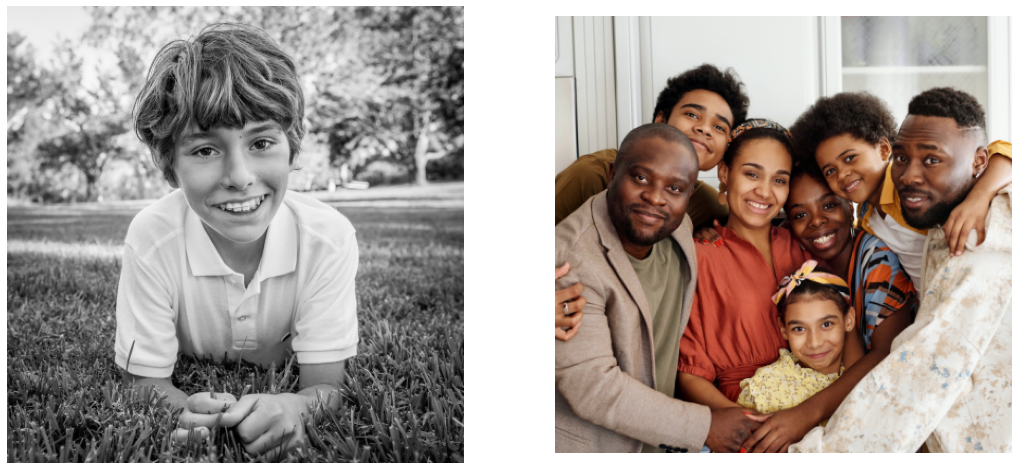

In [ ]:
img1 = cv2.imread('boy.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('family.jpg', cv2.IMREAD_COLOR)

fig = plt.figure(figsize=(18,10))

plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1])
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2[:,:,::-1]);

# 2. Load the DNN Model


<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`cv2.dnn.readNetFromCaffe()`**](https://docs.opencv.org/4.5.2/d6/d0f/group__dnn.html#ga29d0ea5e52b1d1a6c2681e3f7d68473a)
<br>
[**`cv2.dnn.readNet()`**](https://docs.opencv.org/4.5.2/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422)

Note: Either function above can be used, but be aware that the order of the arguments differs between the two funcions.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [ ]:
modelFile = '../model/res10_300x300_ssd_iter_140000.caffemodel'
configFile = '../model/deploy.prototxt'

# Read the model and create a network object.
net = cv2.dnn.readNetFromCaffe(prototxt=configFile, caffeModel=modelFile)

# 3. Rectangular Face Blur


## 3.1 Define a Blurring Function


<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">OpenCV Documentation</font>

[**`GaussianBlur()`**](https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [ ]:
def blur(face, factor=3):

    h, w  = face.shape[:2]

    if factor < 1: factor = 1 # Maximum blurring
    if factor > 5: factor = 5 # Minimal blurring

    # Kernel size.
    w_k = int(w/factor)
    h_k = int(h/factor)

    # Insure kernel is an odd number.
    if w_k%2 == 0: w_k += 1
    if h_k%2 == 0: h_k += 1

    blurred = cv2.GaussianBlur(face, (int(w_k), int(h_k)), 0, 0)
    return blurred

## 3.2 DNN Reference Documentation

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`cv2.dnn.blobFromImage()`**](https://docs.opencv.org/4.5.2/d6/d0f/group__dnn.html#ga98113a886b1d1fe0b38a8eef39ffaaa0)
<br>
[**`cv2.dnn_Net.setInput()`**](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html#a5e74adacffd6aa53d56046581de7fcbd)
<br>
[**`cv2.dnn_Net.forward()`**](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html#a98ed94cb6ef7063d3697259566da310b)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

## 3.3 Face Detection Model References

The following links are provided as references to this face detection model.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(8,133,37)">Caffe Model: res10_300x300_ssd_iter_140000</font>



* [**Model and Configuration Parameters**](https://github.com/opencv/opencv/blob/master/samples/dnn/models.yml)
<br>
* [**Model Architecture File**](https://github.com/opencv/opencv/blob/master/samples/dnn/face_detector/deploy.prototxt)
<br>

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(50,120,230)">Rectangular face blur</font>

In [ ]:
def face_blur_rect(image, net, factor=3, detection_threshold=0.9):

    img = image.copy()

    # Convert the image into a blob format.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])

    # Pass the blob to the DNN model.
    net.setInput(blob)

    # Retrieve detections from the DNN model.
    detections = net.forward()

    (h, w) = img.shape[:2]

    # Process the detetcions.
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")

            # Extract the face ROI.
            face = img[y1:y2, x1:x2]

            face = blur(face, factor=factor)

            # Replace the detected face with the blurred one.
            img[y1:y2, x1:x2] = face

    return img

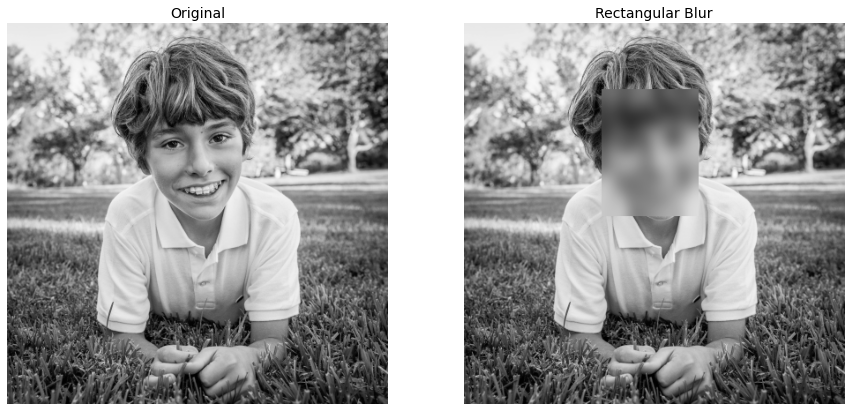

In [ ]:
img1_rect = face_blur_rect(img1, net, factor=2.5)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]); plt.title('Rectangular Blur');

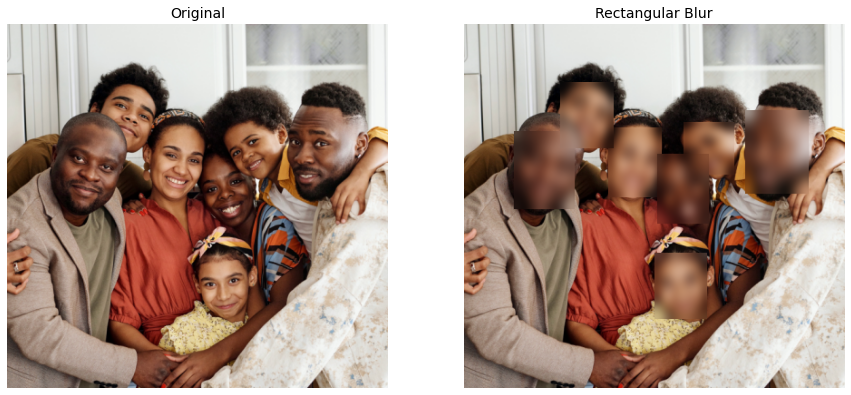

In [ ]:
img2_rect = face_blur_rect(img2, net, factor=2)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]); plt.title('Rectangular Blur');

# 4. Elliptical Face Blur

Next, we will demonstrate how to blur the faces with an elliptical shape that conforms to the natural shape of faces.

## Drawing an Ellipse
We will use the `ellipse()` function to create an elliptical mask.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(8,133,37)">Function Syntax </font>

``` python
img = cv2.ellipse(img, box, color[, thickness[, lineType]])
```

The function has **3 required arguments**:
    
1. `img`	Image.
2. `box`	Alternative ellipse representation via [RotatedRect](https://docs.opencv.org/4.5.2/db/dd6/classcv_1_1RotatedRect.html#ae1be388780b8d5faf450be18cbbf30f1). This means that the function draws an ellipse inscribed in the rotated rectangle.
3. `color`	Ellipse color.

**RotatedRect**:

`center`: The rectangle mass center (x, y).<br>
`size`:	Width and height of the rectangle (w, h).<br>
`angle`: The rotation angle in a clockwise direction.<br>



### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`cv2.ellipse()`**](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga57be400d8eff22fb946ae90c8e7441f9)

[**`np.putmask()`**](https://numpy.org/doc/stable/reference/generated/numpy.putmask.html)
<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(50,120,230)">Elliptical face blur</font>

In [ ]:
def face_blur_ellipse(image, net, factor=3, detect_threshold=0.90, write_mask=False):

    img = image.copy()
    img_blur = img.copy()

    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)

    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]

            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Copy the `blurred_face` to the blurred image.
            img_blur[int(y1):int(y2), int(x1):int(x2), :] = face

            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0

            # Create an elliptical mask.
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle),
                                                      (255, 255, 255), -1, cv2.LINE_AA)
            # Apply the elliptical mask
            np.putmask(img, elliptical_mask, img_blur)

    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

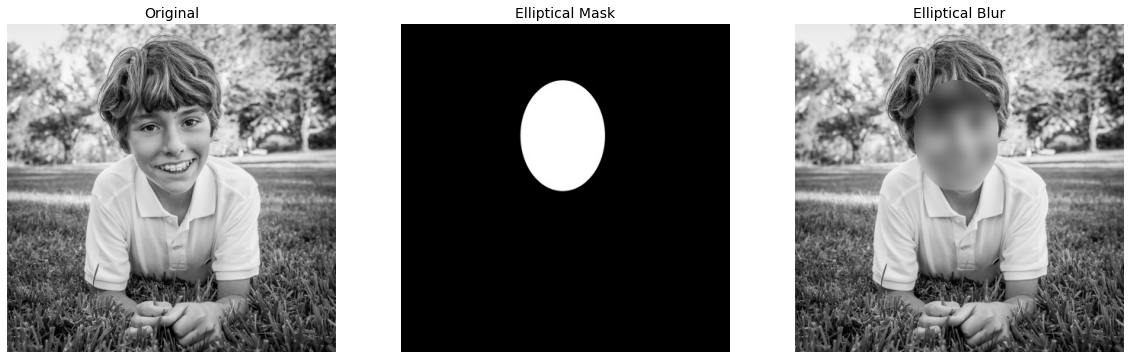

In [ ]:
img1_ellipse = face_blur_ellipse(img1, net, factor=2.5, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

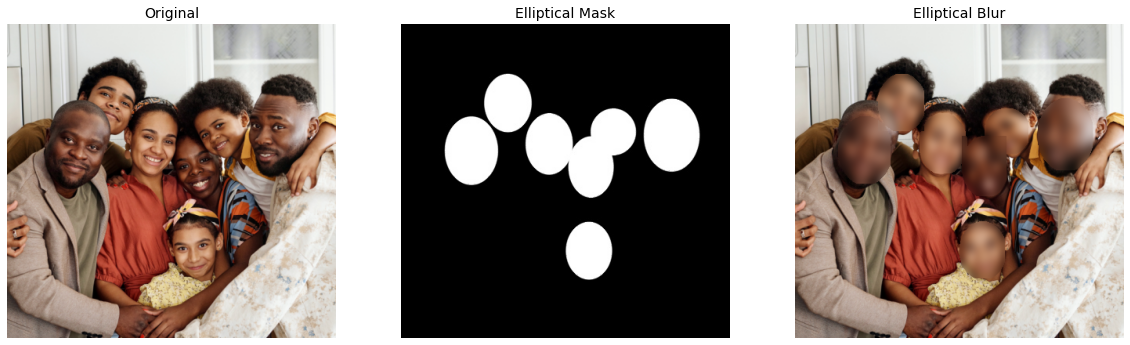

In [ ]:
img2_ellipse = face_blur_ellipse(img2, net, factor=2, write_mask=True)

mask = cv2.imread('elliptical_mask.jpg')
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);                   plt.title('Elliptical Mask')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur');

# 5. Pixelated Face Blur

Pixelating the detected faces can be accomplished by resizing the face at lower resolution.
<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/09/c0-m14-02-Pixelated-Example.jpg' alt='Pixelated_Example'>
</center>
<br>
<hr style="border:none; height: 4px; background-color:#D3D3D3" />


### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`cv2.resize()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(50,120,230)">Define a pixelate function</font>

In [ ]:
def pixelate(roi, pixels=16):

    # Size of region to pixelate.
    roi_h, roi_w = roi.shape[:2]

    if roi_h > pixels and roi_w > pixels:
        # Resize input ROI to the (small) pixelated size.
        roi_small = cv2.resize(roi, (pixels, pixels), interpolation=cv2.INTER_LINEAR)

        # Now enlarge the pixelated ROI to fill the size of the original ROI.
        roi_pixelated = cv2.resize(roi_small, (roi_w, roi_h), interpolation=cv2.INTER_NEAREST)
    else:
        roi_pixelated = roi

    return roi_pixelated

### <font style="color:rgb(50,120,230)">Pixelated face blur</font>

In [ ]:
def face_blur_pixelate(image, net, detection_threshold=0.9, pixels=10):
    img = image.copy()

    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")

            face = img[y1:y2, x1:x2]
            face = pixelate(face, pixels=pixels)
            img[y1:y2, x1:x2] = face

    return img

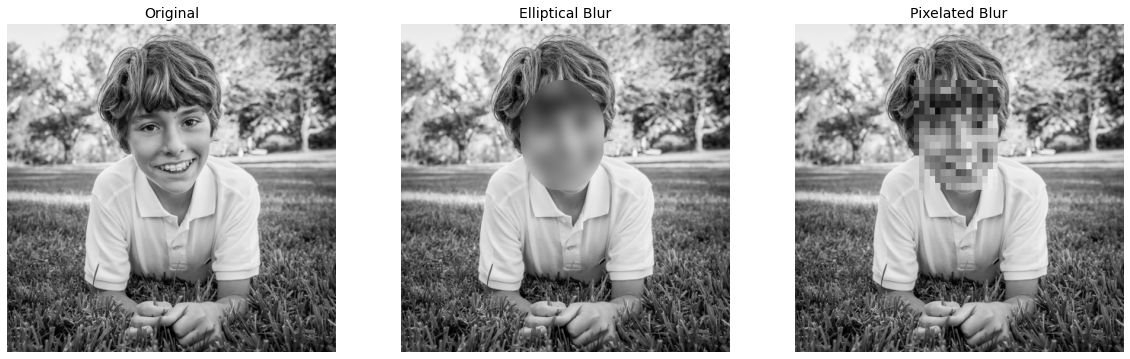

In [ ]:
img1_pixel = face_blur_pixelate(img1, net, pixels=16)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated Blur');

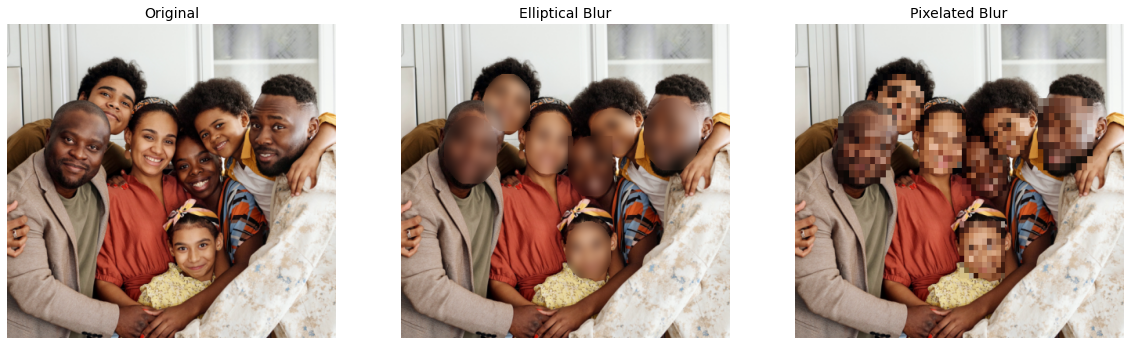

In [ ]:
img2_pixel = face_blur_pixelate(img2, net, pixels=10)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);         plt.title('Original')
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img2_pixel[:,:,::-1]);   plt.title('Pixelated Blur');

# 6. Combined: Elliptical, Blurred and Pixelated

In [ ]:
def face_blur_ellipse_pixelate(image, net, detect_threshold=0.9, factor=3, pixels=10, write_mask=False):

    img = image.copy()
    img_out = img.copy()
    elliptical_mask = np.zeros(img.shape, dtype=img.dtype)

    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detect_threshold:

            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box

            # The face is defined by the bounding rectangle from the detection.
            face = img[int(y1):int(y2), int(x1):int(x2), :]

            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Pixelate the blurred face.
            face = pixelate(face, pixels=pixels)

            # Copy the blurred/pixelated face to the output image.
            img_out[int(y1):int(y2), int(x1):int(x2), :] = face

            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0

            # Create an elliptical mask.
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle),
                                                      (255, 255, 255), -1, cv2.LINE_AA)
            # Apply the elliptical mask.
            np.putmask(img, elliptical_mask, img_out)

    if write_mask:
        cv2.imwrite('elliptical_mask.jpg', elliptical_mask)

    return img

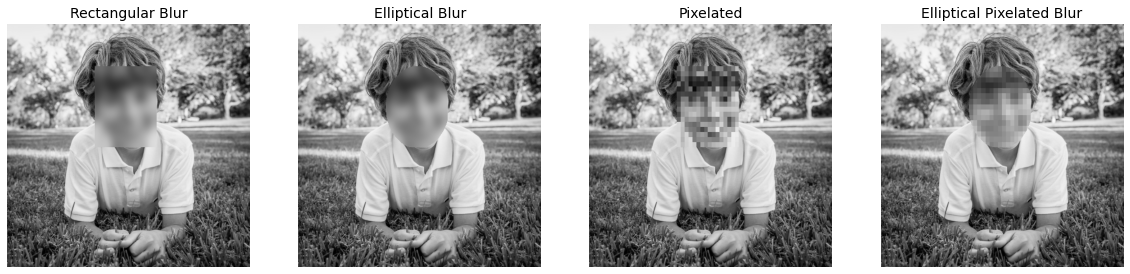

In [ ]:
img1_epb = face_blur_ellipse_pixelate(img1, net, factor=3.5, pixels=15)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]);    plt.title('Rectangular Blur')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(img1_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img1_epb[:,:,::-1]);     plt.title('Elliptical Pixelated Blur');

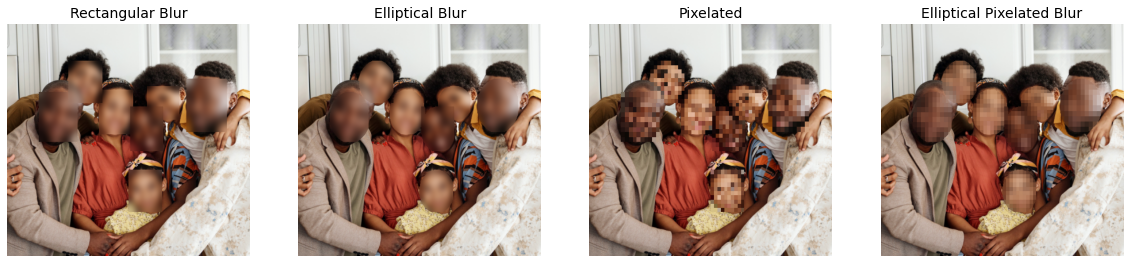

In [ ]:
img2_epb = face_blur_ellipse_pixelate(img2, net, factor=2, pixels=10)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,4,1); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]);    plt.title('Rectangular Blur')
plt.subplot(1,4,2); plt.axis('off'); plt.imshow(img2_ellipse[:,:,::-1]); plt.title('Elliptical Blur')
plt.subplot(1,4,3); plt.axis('off'); plt.imshow(img2_pixel[:,:,::-1]);   plt.title('Pixelated')
plt.subplot(1,4,4); plt.axis('off'); plt.imshow(img2_epb[:,:,::-1]);     plt.title('Elliptical Pixelated Blur');